# Counting cells with a Poisson noise model
A core component of all calibration models are the distribution that describes the spread of measurements, also known as the _noise model_.
If the noise models already provided by `calibr8` don't match for your application, you can implement your own noise model by following the example below.

In [1]:
import calibr8
import numpy
import scipy.stats
from matplotlib import pyplot

## Implementing a noise model
Noise models must inherit from `calibr8.DistributionMixin` and implement at least the following:

* A `scipy_dist` class attribute to identify a SciPy probability distribution.
* A `to_scipy` method to map the tuple of parameters returned by the `predict_dependent` method to a dictionary of keyword arguments for `scipy_dist`.

Note that the class inheriting the noise model is responsible to implement `predict_dependent` such that the mapping methods apply.
We encourage everybody to [write unit tests for custom noise models](https://github.com/JuBiotech/calibr8/blob/v6.2.0/calibr8/tests.py#L145).

In [2]:
class PoissonNoise(calibr8.DistributionMixin):
    scipy_dist = scipy.stats.poisson

    @staticmethod
    def to_scipy(*params):
        return dict(mu=params[0])
    
# Note: A `PoissonNoise` model with optional PyMC support is already included in calibr8.

## Using the noise model in a custom calibration model
The custom noise model mixin can be used just like any other noise model.

To set up a calibration model for cell dry weight vs. number of cells counted in a counting chamber, we can wire up the Poisson's only parameter as proportional to the cell dry weight.

In [3]:
class CellCountCalibration(calibr8.ContinuousUnivariateModel, PoissonNoise):
    def __init__(self):
        super().__init__(
            independent_key="cell dry weight [g/L]",
            dependent_key="cells counted [-]",
            theta_names=["slope"]
        )

    def predict_dependent(self, x, *, theta=None):
        if theta is None:
            theta = self.theta_fitted
        slope = theta[0]
        # Always return a tuple 👇
        return (slope * x,)

ccc = CellCountCalibration()

### Fitting the model to toy data
As with other examples, we need some data to play with.
Let's say we have some calibration data points with known cell dry weight and a corresponding cell count.

In [4]:
# Ten known cell dry weights [g/L].
cdw = numpy.linspace(1, 20, 10)

rng = numpy.random.RandomState(20211122)
# Using 0.5 as the slope gives us a clearly distinguishable y-axis later.
obs = rng.poisson(lam=cdw * 0.5)

_, history = calibr8.fit_scipy(
    ccc,
    independent=cdw,
    dependent=obs,
    theta_guess=[1],
    theta_bounds=[(0.1, 10)],
)

## Visualizing the fitted model
For visualizing this model, we need to think about how to deal with the discrete dependent variable.
Let's try a heatmap to discretize the y-axis, but use a high resolution on the x-axis to make it look continuous.

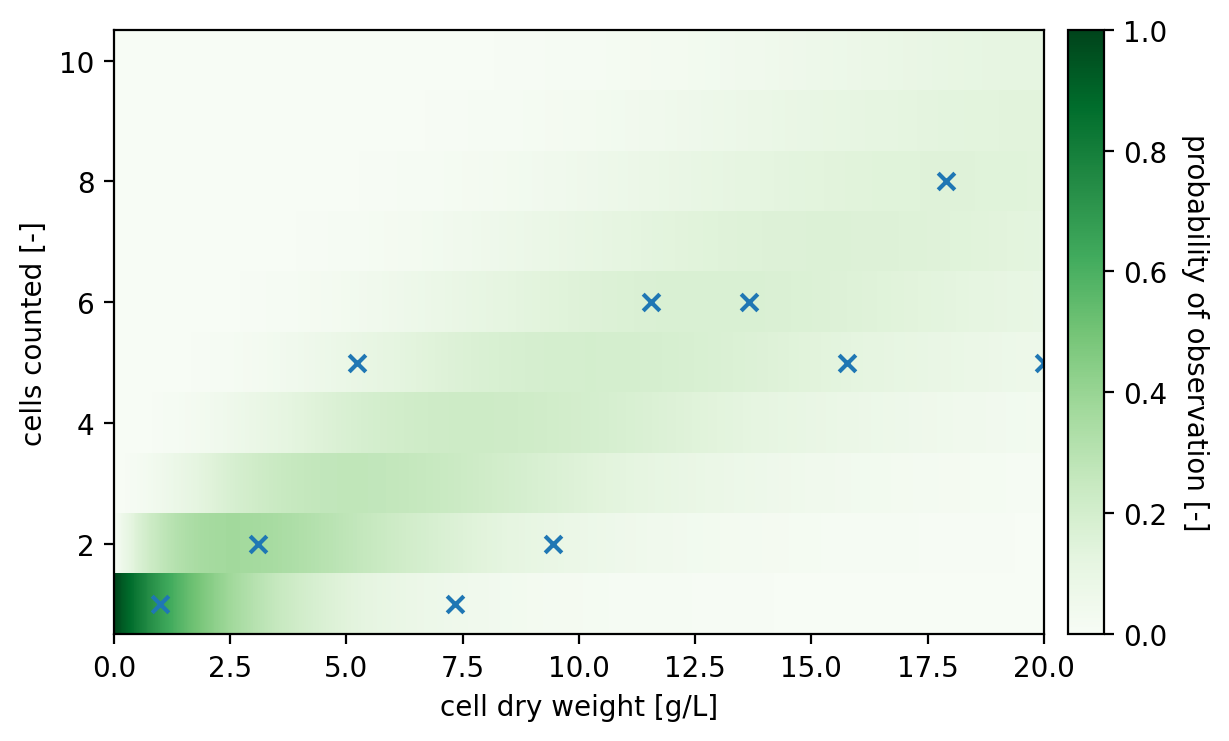

In [5]:
fig, ax = pyplot.subplots(dpi=200)

xdense = numpy.linspace(0.01, 20, 1000)
ydense = numpy.arange(0, 10)
p = ccc.scipy_dist.pmf(
    ydense[:, None],
    mu=ccc.predict_dependent(xdense)[0][None, :]
)

sm = ax.imshow(
    p[::-1, :],
    extent=(0.01, 20, 0.5, 10.5),
    aspect="auto",
    interpolation="none",
    cmap=pyplot.cm.Greens,
    vmax=1,
)
cbar = pyplot.colorbar(
    sm,
    cax=fig.add_axes([0.92,0.126,0.03,0.7545]),
)
cbar.set_label("probability of observation [-]", rotation=270, labelpad=15)
ax.scatter(cdw, obs, marker="x")
ax.set(
    ylabel=ccc.dependent_key,
    xlabel=ccc.independent_key,
    ylim=(0.5, None),
    xlim=(0, None),
)

pyplot.show()

## Applying the model for UQ
Assuming that from one sample we have counted cells twice, can we now state our uncertainty about the cell dry weight in this sample?

With a prior belief that we can't have less than 0 and more than 20 g/L cell dry weight, 
and after observing 4 and 5 cells, our posterior belief is that the 
cell dry weight of our sample is in the [6.88, 18.20] g/L interval with a 90 % chance.


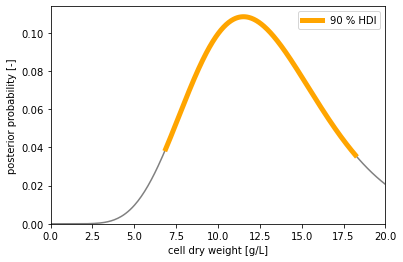

In [6]:
def show_posterior(pst, yobs):
    print(
        "With a prior belief that we can't have less than 0 "
        "and more than 20 g/L cell dry weight, \n"
        f"and after observing {', '.join(map(str, yobs[:-1]))} and {yobs[-1]} cells, "
        "our posterior belief is that the \ncell dry weight of our sample "
        f"is in the [{pst.hdi_lower:.2f}, {pst.hdi_upper:.2f}] g/L interval "
        f"with a {pst.hdi_prob*100:.0f} % chance."
    )
    
    fig, ax = pyplot.subplots()

    pst_full = ccc.infer_independent(y=yobs, lower=0, upper=20)
    ax.plot(pst_full.eti_x, pst_full.eti_pdf, color="gray")
    ax.plot(pst.hdi_x, pst.hdi_pdf, lw=5, label=f"{pst.hdi_prob*100:.0f} % HDI", color="orange")
    ax.set(
        ylim=(0, None),
        ylabel="posterior probability [-]",
        xlim=(0, 20),
        xlabel="cell dry weight [g/L]",
    )
    ax.legend()

    pyplot.show()

yobs = [4, 5]
pst = ccc.infer_independent(y=yobs, lower=0, upper=20, ci_prob=0.9)
show_posterior(pst, yobs)

Oh, this is not very accurate!
Can we get a more accurate estimate of the cell dry weight by cell-counting multiple times?

With a prior belief that we can't have less than 0 and more than 20 g/L cell dry weight, 
and after observing 4, 5, 4, 6, 3 and 7 cells, our posterior belief is that the 
cell dry weight of our sample is in the [8.98, 16.51] g/L interval with a 90 % chance.


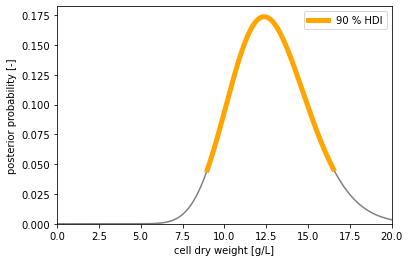

In [7]:
yobs2 = yobs + [4, 6, 3, 7]
pst2 = ccc.infer_independent(y=yobs2, lower=0, upper=20, ci_prob=0.9)
show_posterior(pst2, yobs2)

As expected: More observations give more accurate results.

## Conclusion
In this example we have seen how to implement a custom noise model, and build a calibration model with it.

Furthermore, this example demonstrated that key components of `calibr8` such as `fit_scipy` or `infer_independent` are agnostic to wheather the noise model is a continuous or discrete distribution.

This specific application showed that `calibr8` brings everything needed to do uncertainty quantification for cell-counting experiments.

In [8]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Nov 22 2021

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.24.1

numpy     : 1.19.2
calibr8   : 6.1.3
scipy     : 1.5.2
matplotlib: 3.3.2

Watermark: 2.2.0

